# 1. Preprocess dataset 

In [16]:
import csv
import re

from collections import Counter
from gensim.models import Word2Vec
from random import random
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from torch import nn
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn.functional as F

In [17]:
train_emotion = []
train_tweets = []
with open('dataset/train.csv', encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: continue
        emotion = row[0]
        tweet = row[1]
        tweet = tweet.replace('@USERNAME', '')
        tweet = tweet.replace('[#TRIGGERWORD#]', '')
        tweet = result = re.sub(r"http\S+", "", tweet)
        train_tweets.append(tweet)
        train_emotion.append(emotion)

In [18]:
sentences = train_tweets

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
word_counts = Counter([word for sentence in sentences for word in sentence])
vocabulary = ["<UNK>"] + [e[0] for e in list(word_counts.items()) if e[1] > 2]
vocabularySize = len(vocabulary)
word2index = {word:index for index,word in enumerate(vocabulary)}
one_hot_embeddings = np.eye(vocabularySize)

In [19]:
# Create emotion array
emotions = sorted(list(set(train_emotion)))
emotions

['anger', 'disgust', 'fear', 'joy', 'sad', 'surprise']

In [134]:
# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
w2v = Word2Vec(filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.vectors))

In [21]:
def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentence, predicted_sentence):
    """
    Given a reference sentence, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = word_tokenize(reference_sentence.lower())
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu([reference_tokenized], predicted_tokenized)

# 1. Build a Emotion Decoder

In [129]:
use_cuda = False
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = F.relu(input)
        output, hidden = self.lstm(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1) 
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
'''
# decoder for one hot embedding
decoder=DecoderLSTM(input_size=len(vocabulary), 
                    hidden_size=300, 
                    output_size=len(emotions))
'''
# decoder for word2vec embedding
decoder=DecoderLSTM(input_size=wordEncodingSize, 
                    hidden_size=300, 
                    output_size=len(emotions))
decoder

DecoderLSTM(
  (lstm): LSTM(300, 300)
  (out): Linear(in_features=300, out_features=6, bias=True)
)

# 2. Train the Emotion Decoder

In [122]:
# build some helper function
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [124]:
def train(target_variable, 
          emotion,
          decoder, 
          decoder_optimizer, 
          criterion, 
          embeddings=w2v_embeddings,
          teacher_force=True): 
    """
    Given a single training sample, go through a single step of training.
    """
    loss = 0
    decoder_optimizer.zero_grad()
    
    decoder_input = Variable(torch.FloatTensor([[embeddings[target_variable[0].data[0]]]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = (decoder.initHidden(), decoder.initHidden())

    for di in range(0,target_variable.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)

        if teacher_force:
            ni = target_variable[di].data[0]
        else:          
            ni = topi[0][0]
        
        decoder_input = Variable(torch.FloatTensor([[embeddings[ni]]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        if di == target_variable.size(0) - 2: 
            loss += criterion(decoder_output, emotion)
        if vocabulary[ni] == "<EOS>":
            break

    loss.backward()
    
    torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0)

    decoder_optimizer.step()

    return loss.data[0] / target_variable.size(0)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()  

num_epochs = 1
numberized_emotion = [emotions.index(emotion) for emotion in train_emotion]
target_emotion = Variable(torch.LongTensor(numberized_emotion))
start = time.time()
total_loss = 0
avg_loss = []
for _ in range(num_epochs):
    for i,sentence in enumerate(train_tweets):
        
        numberized = preprocess_numberize(sentence)
        if len(numberized) == 2:
            continue
        target_variable = Variable(torch.LongTensor(numberized[1:]))

        loss = train(target_variable, target_emotion[i], decoder, decoder_optimizer, criterion)
        total_loss += loss
        avg_loss.append(total_loss/(i+1))
        if i % 1000 == 0:
            print('%s (%d %d%%) %.6f' % 
                  (timeSince(start, (i+1)/len(train_tweets)), i, (i+1)/len(train_tweets)*100, total_loss/(i+1)))
    name = 'decoder_biLSTM_ep' + str(_ + 1) + '.pt'
    torch.save(decoder.state_dict(), name)

0m 0s (- 319m 16s) (0 0%) 0.090516
2m 38s (- 403m 2s) (1000 0%) 0.101205
5m 18s (- 401m 19s) (2000 1%) 0.101878
7m 56s (- 397m 52s) (3000 1%) 0.101043
10m 36s (- 395m 49s) (4000 2%) 0.100553
13m 12s (- 391m 32s) (5000 3%) 0.100640
15m 49s (- 388m 35s) (6000 3%) 0.100328
18m 27s (- 385m 43s) (7000 4%) 0.100192
21m 4s (- 382m 36s) (8000 5%) 0.100152
23m 40s (- 379m 25s) (9000 5%) 0.100499
26m 15s (- 376m 7s) (10000 6%) 0.100300
28m 53s (- 373m 38s) (11000 7%) 0.099975
31m 30s (- 370m 52s) (12000 7%) 0.099711
34m 10s (- 368m 50s) (13000 8%) 0.099319
36m 45s (- 365m 42s) (14000 9%) 0.098944
39m 23s (- 363m 6s) (15000 9%) 0.098674
42m 0s (- 360m 21s) (16000 10%) 0.098387
44m 37s (- 357m 41s) (17000 11%) 0.098172
47m 16s (- 355m 16s) (18000 11%) 0.098007
49m 59s (- 353m 15s) (19000 12%) 0.097678
52m 42s (- 351m 12s) (20000 13%) 0.097320
55m 23s (- 348m 54s) (21000 13%) 0.097033
58m 6s (- 346m 45s) (22000 14%) 0.096798
60m 55s (- 345m 3s) (23000 15%) 0.096501
63m 42s (- 343m 7s) (24000 15%) 0

<Figure size 432x288 with 0 Axes>

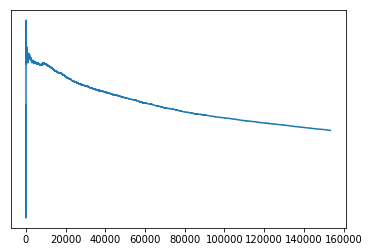

In [130]:
len(train_tweets)
showPlot(avg_loss)

In [56]:
# after training, save model 
name = 'decoder4ep' + 'test' + '.pt'
torch.save(decoder.state_dict(), name)

In [131]:
# load previously training model:
decoder.load_state_dict(torch.load('decoder_nonstop_ep0.pt'))


# 3. Evaluate the Emotion decoder

In [125]:
dev_tweets = []
with open('dataset/dev.csv', encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True, quoting=csv.QUOTE_NONE)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: continue
        tweet = row[1]
        tweet = tweet.replace('@USERNAME', '')
        tweet = tweet.replace('[#TRIGGERWORD#]', '')
        tweet = result = re.sub(r"http\S+", "", tweet)
        dev_tweets.append(tweet)

In [126]:
dev_emotions = []
with open('dataset/trial-v3.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: continue
        dev_emotions.append(row[0])

In [132]:
actual_result = []
def evaluate(decoder, 
             target_variable, 
             embeddings=w2v_embeddings, 
             teacher_force=True):
    
    decoder_input = Variable(torch.FloatTensor([[embeddings[target_variable[0].data[0]]]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = (decoder.initHidden(),decoder.initHidden())
    
    softmax = nn.Softmax()
    for di in range(0,target_variable.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        
        if teacher_force:
            ni = target_variable[di].data[0]
        else:          
            ni = topi[0][0]

        decoder_input = Variable(torch.FloatTensor([[embeddings[ni]]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        if di == target_variable.size(0) - 2: # last output 
            actual_result.append(emotions[topi[0][0]])

            if dev_emotions[i] == emotions[topi[0][0]]:
                return True
            #print (dev_emotions[i], emotions[topi[0][0]])
            
        if vocabulary[ni] == "<EOS>":
            break
    return False

# evaluate the model
print ("ground truth, model prediction")
correct_prediction_counts = 0
for i,tweet in enumerate(dev_tweets): 
    numberized = preprocess_numberize(tweet)
    if len(numberized) == 2: continue
    target_variable = Variable(torch.LongTensor(numberized[1:]))
    
    if evaluate(decoder, target_variable):
        correct_prediction_counts += 1
    
    if i % 100 == 0:
        print (correct_prediction_counts, " correct predictions in ", i+1)
        print ("acurray: ", correct_prediction_counts/(i+1))


ground truth, model prediction
1  correct predictions in  1
acurray:  1.0
51  correct predictions in  101
acurray:  0.504950495049505
101  correct predictions in  201
acurray:  0.5024875621890548
154  correct predictions in  301
acurray:  0.5116279069767442
205  correct predictions in  401
acurray:  0.5112219451371571
257  correct predictions in  501
acurray:  0.5129740518962076
305  correct predictions in  601
acurray:  0.5074875207986689
362  correct predictions in  701
acurray:  0.5164051355206848
405  correct predictions in  801
acurray:  0.5056179775280899
446  correct predictions in  901
acurray:  0.49500554938956715
490  correct predictions in  1001
acurray:  0.48951048951048953
540  correct predictions in  1101
acurray:  0.4904632152588556
587  correct predictions in  1201
acurray:  0.488759367194005
635  correct predictions in  1301
acurray:  0.4880860876249039
678  correct predictions in  1401
acurray:  0.48394004282655245
723  correct predictions in  1501
acurray:  0.4816788

Labels: sad;surprise;anger;disgust;joy;fear
Label	TP	FP	FN	P	R	F
sad	397	280	1063	0.586	0.272	0.372
surpris	697	799	903	0.466	0.436	0.45
anger	691	1077	909	0.391	0.432	0.41
disgust	908	1198	689	0.431	0.569	0.49
joy	983	622	753	0.612	0.566	0.588
fear	891	1048	707	0.46	0.558	0.504
MicAvg	4567	5024	5024	0.476	0.476	0.476
MacAvg				0.491	0.472	0.469
Official result: 0.4691360641845818


,anger,disgust,fear,joy,sad,surprise
anger,691,254,231,155,59,210
disgust,205,908,147,78,76,183
fear,236,176,891,91,39,165
joy,174,147,258,983,54,120
sad,248,325,184,185,397,121
surprise,214,296,228,113,52,697


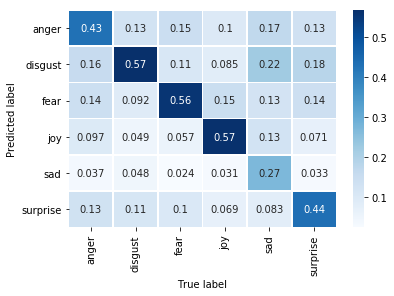

In [133]:
#!/usr/bin/env python
# Author: roman.klinger@ims.uni-stuttgart.de
# Evaluation script for IEST at WASSA 2018
from __future__ import print_function
import sys
import itertools
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import random

test_result = []
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

def welcome():
    eprint("====================================")
    eprint("Evaluation script v0.2 for the Implicit Emotions Shared Task 2018.")
    eprint("Please call it via")
    eprint("./evaluate-iest.py <gold> <prediction>")
    eprint("where each csv file has labels in its first column.")
    eprint("The rows correspond to each other (1st row in <gold>")
    eprint("is the gold label for the 1st column in <prediction>).")
    eprint("")
    eprint("If you have questions, please contact klinger@wassa2018.com")
    eprint("====================================\n\n")

def checkParameters():
    if ((len(sys.argv) < 3 or len(sys.argv) > 3)):
        eprint("Please call the script with two files as parameters.")
        sys.exit(1)

def readFileToList(filename):
    eprint("Reading data from",filename)
    f=open(filename,"r")
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split('\t')[0].rstrip())
    f.close()
    eprint("Read",len(result),"labels.")
    return result

def calculatePRF(gold,prediction):
    # initialize counters
    labels = set(gold+prediction)
    print("Labels: "+';'.join(labels))
    tp = dict.fromkeys(labels, 0.0)
    fp = dict.fromkeys(labels, 0.0)
    fn = dict.fromkeys(labels, 0.0)
    precision = dict.fromkeys(labels, 0.0)
    recall = dict.fromkeys(labels, 0.0)
    f = dict.fromkeys(labels, 0.0)
    # check every element
    for g,p in zip(gold,prediction):
        #        print(g,p)
        # TP 
        if (g == p):
            tp[g] += 1
        else:
            fp[p] += 1
            fn[g] += 1
    # print stats
    print("Label\tTP\tFP\tFN\tP\tR\tF")
    for label in labels:
        recall[label] = 0.0 if (tp[label]+fn[label]) == 0.0 else (tp[label])/(tp[label]+fn[label])
        precision[label] = 1.0 if (tp[label]+fp[label]) == 0.0 else (tp[label])/(tp[label]+fp[label])
        f[label] = 0.0 if (precision[label]+recall[label])==0 else (2*precision[label]*recall[label])/(precision[label]+recall[label])
        print(label[:7]+
            "\t"+str(int(tp[label]))+
            "\t"+str(int(fp[label]))+
            "\t"+str(int(fn[label]))+
            "\t"+str(round(precision[label],3))+
            "\t"+str(round(recall[label],3))+
            "\t"+str(round(f[label],3))
            )
        # micro average
        microrecall = (sum(tp.values()))/(sum(tp.values())+sum(fn.values()))
        microprecision = (sum(tp.values()))/(sum(tp.values())+sum(fp.values()))
        microf = 0.0 if (microprecision+microrecall)==0 else (2*microprecision*microrecall)/(microprecision+microrecall)
    # Micro average
    print("MicAvg"+
        "\t"+str(int(sum(tp.values())))+
        "\t"+str(int(sum(fp.values())))+
        "\t"+str(int(sum(fn.values())))+
        "\t"+str(round(microprecision,3))+
        "\t"+str(round(microrecall,3))+
        "\t"+str(round(microf,3))
        )
    # Macro average
    macrorecall = sum(recall.values())/len(recall)
    macroprecision = sum(precision.values())/len(precision)
    macroF = sum(f.values())/len(f)
    print("MacAvg"+
        "\t"+str( )+
        "\t"+str( )+
        "\t"+str( )+
        "\t"+str(round(macroprecision,3))+
        "\t"+str(round(macrorecall,3))+
        "\t"+str(round(macroF,3))
        )
    print("Official result:",macroF)
    
    test_result.append(macroF)
    
if (len(actual_result) != len(dev_emotions)):
    eprint("Number of labels is not aligned!")
    sys.exit(1)
calculatePRF(dev_emotions,actual_result)

percent_matrix = [[0 for col in range(6)] for row in range(6)]
for i in range(len(dev_emotions)):
    percent_matrix[emotions.index(dev_emotions[i])][emotions.index(actual_result[i])] += 1

dim_matrix = len(percent_matrix)
col_sum = [0] * len(emotions)
for i in range(dim_matrix):
    for j in range(dim_matrix):
        col_sum[i] = col_sum[i] + percent_matrix[i][j]
        
for i in range(len(percent_matrix)):
    for j in range(len(percent_matrix)):
        percent_matrix[i][j] = percent_matrix[i][j] / col_sum[i]
        
percent_matrix = [[0 for col in range(6)] for row in range(6)]
for i in range(len(dev_emotions)):
    percent_matrix[emotions.index(dev_emotions[i])][emotions.index(actual_result[i])] += 1
    
tmp_matrix=pd.DataFrame(percent_matrix, columns = emotions, index = emotions)
display(HTML(tmp_matrix.to_html()))
dim_matrix = len(percent_matrix)
col_sum = [0] * len(emotions)
for i in range(dim_matrix):
    for j in range(dim_matrix):
        col_sum[i] = col_sum[i] + percent_matrix[i][j]
        
for i in range(len(percent_matrix)):
    for j in range(len(percent_matrix)):
        percent_matrix[i][j] = percent_matrix[i][j] / col_sum[i]
        
percent_matrix=pd.DataFrame(percent_matrix, columns = emotions, index = emotions)
# display(HTML(percent_matrix.to_html()))

# plot heatmap
ax = sns.heatmap(percent_matrix.T, annot=True, linewidths=.5, cmap="Blues")

# turn the axis label
for item in ax.get_xticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.ylabel("Predicted label")
plt.xlabel("True label")
# save figure
plt.savefig('resultHeatmap.png', dpi=100)
plt.show()